# Simulating pET19K_MaSp1_4 Production Limits

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b_pET19K_MaSp1_4.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## Find Broad Upper Production Limit

In [4]:
from contextlib import suppress

MaSp1 = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
growth_rate = []
for x in MaSp1:
    print('\nMaSp1 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp1').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp1').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate.append(temp)
    print('Growth-rate =', growth_rate)
    
growth_rate


MaSp1 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.511813 seconds
Finished substituting S,lb,ub in 2.349646 seconds
Finished makeME_LP in 0.373428 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.266875 seconds
Finished makeME_LP in 0.367245 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.298684 seconds
Finished makeME_LP in 0.363264 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.307768 seconds
Finished makeME_LP in 0.361830 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.331928 seconds
Finished makeME_LP in 0.368121 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.333313 seconds
Finished makeME_LP in 0.381296 seconds

2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.496704 seconds
Finished makeME_LP in 0.379871 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.523065 seconds
Finished makeME_LP in 0.378501 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.630902 seconds
Finished makeME_LP in 0.427168 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.484383 seconds
Finished makeME_LP in 0.417300 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.455879 seconds
Finished makeME_LP in 0.401572 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 531.868 seconds
Growth-rate = [0.828125, 0.796875, 0.6328125, 0, 0, 0, 0]


[0.828125, 0.796875, 0.6328125, 0, 0, 0, 0]

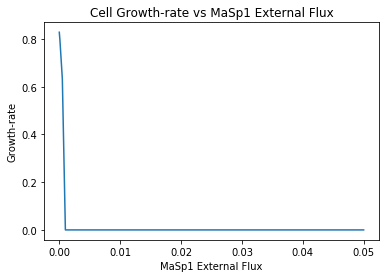

In [5]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp1 External Flux')
  
# function to show the plot
plt.show()

## Find Exact Upper Production Limit

In [6]:
from contextlib import suppress

MaSp1 = [0, 0.0001, 0.0005, 0.0006, 0.00065, 0.00066, 0.00067]
growth_rate2 = []
for x in MaSp1:
    print('\nMaSp1 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp1').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp1').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate2.append(temp)
    print('Growth-rate =', growth_rate2)
    
growth_rate2


MaSp1 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 35.141716 seconds
Finished substituting S,lb,ub in 2.492046 seconds
Finished makeME_LP in 0.378443 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.474400 seconds
Finished makeME_LP in 0.387555 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.545274 seconds
Finished makeME_LP in 0.379781 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.599130 seconds
Finished makeME_LP in 0.392544 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.544665 seconds
Finished makeME_LP in 0.394699 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.529407 seconds
Finished makeME_LP in 0.385770 seconds

1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 2.221007 seconds
Finished makeME_LP in 0.364450 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.230669 seconds
Finished makeME_LP in 0.353704 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.233709 seconds
Finished makeME_LP in 0.361396 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.271875 seconds
Finished makeME_LP in 0.362248 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.212732 seconds
Finished makeME_LP in 0.358198 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.218229 seconds
Finished makeME_LP in 0.359175 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 508.917 seconds
Growth-rat

[0.828125, 0.796875, 0.6328125, 0.5703125, 0.5234375, 0.5078125, 0]

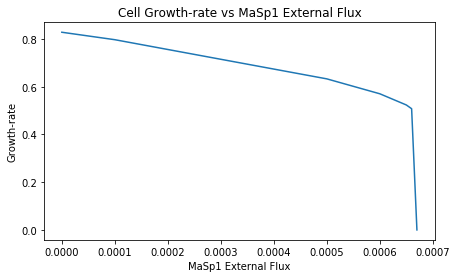

In [7]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1
# corresponding y axis values
y = growth_rate2

plt.figure(figsize=(7,4))

# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp1 External Flux')
  
# function to show the plot
plt.show()